In [ ]:
import os
import pandas as pd
import numpy as np
import re
import gc
from collections import Counter

In [ ]:
OUT_DIR = '/content/drive/MyDrive/scada_analysis/'
input_file = os.path.join(OUT_DIR, "scada_full_raw_compatible.csv")
output_file = os.path.join(OUT_DIR, "scada_windowed_scada_aware.csv")

In [ ]:
#READ IMPROVED DATASET

df2= pd.read_csv(os.path.join(OUT_DIR,"scada_full_raw_compatible.csv"))
df2

,frame.number,time_rel,ip.src,ip.dst,frame.len,info,protocol_final,day_label,source_file
0,1,0.000000,172.17.0.60,172.17.0.22,66.0,1031 → 20000 [ACK] Seq=1 Ack=1 Win=16367 Len=0,tcp,Normal,day1_02_10_20
1,2,0.000320,172.17.0.60,172.17.0.21,66.0,1030 → 20000 [ACK] Seq=1 Ack=1 Win=16384 Len=0,tcp,Normal,day1_02_10_20
2,3,0.000860,172.17.0.38,172.17.0.33,66.0,502 → 58980 [FIN,tcp,Normal,day1_02_10_20
3,4,0.001152,172.17.0.33,172.17.0.38,66.0,58980 → 502 [ACK] Seq=1 Ack=2 Win=8192 Len=0,tcp,Normal,day1_02_10_20
4,5,0.074918,172.17.0.32,172.17.0.38,66.0,65001 → 502 [SYN] Seq=0 Win=4096 Len=0 MSS=1460,tcp,Normal,day1_02_10_20
...,...,...,...,...,...,...,...,...,...
11024238,2551491,29538.939547,172.17.0.38,172.17.0.33,66.0,502 → 56253 [FIN,tcp,Attack,day6_03_19_20
11024239,2551492,29538.939805,172.17.0.33,172.17.0.38,66.0,56253 → 502 [ACK] Seq=16 Ack=14 Win=8192 Len=0,tcp,Attack,day6_03_19_20
11024240,2551493,29538.945104,172.17.0.60,172.17.0.22,84.0,Read,dnp 3.0,Attack,day6_03_19_20
11024241,2551494,29538.947122,172.17.0.22,172.17.0.60,77.0,Response,dnp 3.0,Attack,day6_03_19_20


## per-window feature engineering


since the paper used frame-level features. we can get better detection with sliding windows ( 1s windows) and aggregated statistics per (src,dst) pair.

We will compute for windows of W=1.0 second and also packet-count windows of N=100 packets (both). Features per window:

- count, mean_len, std_len, min_len, max_len

- unique_src_count, unique_dst_count

- protocol distribution (one-hot / entropy)

- avg_interarrival, std_interarrival

- info-text features: tf-idf top-k per window (optional heavy)

In [ ]:

# ==================== SCADA Protocol Parsers (Vectorized) ====================

def parse_modbus_vectorized(info_series):
    """Vectorized Modbus parsing - much faster than apply()"""
    info_lower = info_series.astype(str).str.lower()

    results = pd.DataFrame(index=info_series.index)
    results['modbus_function_code'] = None
    results['modbus_exception'] = 0

    # Function codes - vectorized matching
    results.loc[info_lower.str.contains('read coils', na=False), 'modbus_function_code'] = 1
    results.loc[info_lower.str.contains('read discrete', na=False), 'modbus_function_code'] = 2
    results.loc[info_lower.str.contains('read holding', na=False), 'modbus_function_code'] = 3
    results.loc[info_lower.str.contains('read input', na=False), 'modbus_function_code'] = 4
    results.loc[info_lower.str.contains('write single coil', na=False), 'modbus_function_code'] = 5
    results.loc[info_lower.str.contains('write single register', na=False), 'modbus_function_code'] = 6
    results.loc[info_lower.str.contains('write multiple', na=False), 'modbus_function_code'] = 15

    # Exceptions
    results.loc[info_lower.str.contains('exception|error', na=False), 'modbus_exception'] = 1

    return results


def parse_dnp3_vectorized(info_series):
    """Vectorized DNP3 parsing"""
    info_lower = info_series.astype(str).str.lower()

    results = pd.DataFrame(index=info_series.index)
    results['dnp3_function_code'] = None
    results['dnp3_iin'] = 0

    # Function codes
    results.loc[info_lower.str.contains('confirm', na=False), 'dnp3_function_code'] = 0
    results.loc[info_lower.str.contains('read', na=False), 'dnp3_function_code'] = 1
    results.loc[info_lower.str.contains('write', na=False), 'dnp3_function_code'] = 2
    results.loc[info_lower.str.contains('response', na=False), 'dnp3_function_code'] = 129

    # IIN flags
    results.loc[info_lower.str.contains('iin|device restart', na=False), 'dnp3_iin'] = 1

    return results


def parse_iec104_vectorized(info_series):
    """Vectorized IEC-104 parsing"""
    info_lower = info_series.astype(str).str.lower()

    results = pd.DataFrame(index=info_series.index)
    results['iec104_type_id'] = None

    # Type IDs
    results.loc[info_lower.str.contains('m_sp_na', na=False), 'iec104_type_id'] = 1
    results.loc[info_lower.str.contains('m_dp_na', na=False), 'iec104_type_id'] = 3
    results.loc[info_lower.str.contains('m_me_na', na=False), 'iec104_type_id'] = 9
    results.loc[info_lower.str.contains('c_sc_na', na=False), 'iec104_type_id'] = 45
    results.loc[info_lower.str.contains('c_dc_na', na=False), 'iec104_type_id'] = 46

    return results


# ==================== Memory-Efficient Windowing ====================

def process_file_chunk(chunk_df, window_sec=1.0):
    """Process a single file's data in memory-efficient way"""

    # Sort by time
    chunk_df = chunk_df.sort_values('frame.number').reset_index(drop=True)
    chunk_df['time_rel'] = pd.to_numeric(chunk_df['time_rel'], errors='coerce').fillna(0.0)
    chunk_df['frame.len'] = pd.to_numeric(chunk_df['frame.len'], errors='coerce').fillna(0)

    # Extract SCADA features based on protocol
    protocol_lower = chunk_df['protocol_final'].astype(str).str.lower()

    # Initialize feature columns
    modbus_mask = protocol_lower.str.contains('modbus', na=False)
    dnp3_mask = protocol_lower.str.contains('dnp3', na=False)
    iec104_mask = protocol_lower.str.contains('iec|104', na=False)

    # Parse protocols (only for relevant packets)
    if modbus_mask.any():
        modbus_feats = parse_modbus_vectorized(chunk_df.loc[modbus_mask, 'info'])
        chunk_df = chunk_df.join(modbus_feats, how='left')
    else:
        chunk_df['modbus_function_code'] = None
        chunk_df['modbus_exception'] = 0

    if dnp3_mask.any():
        dnp3_feats = parse_dnp3_vectorized(chunk_df.loc[dnp3_mask, 'info'])
        chunk_df = chunk_df.join(dnp3_feats, how='left')
    else:
        chunk_df['dnp3_function_code'] = None
        chunk_df['dnp3_iin'] = 0

    if iec104_mask.any():
        iec104_feats = parse_iec104_vectorized(chunk_df.loc[iec104_mask, 'info'])
        chunk_df = chunk_df.join(iec104_feats, how='left')
    else:
        chunk_df['iec104_type_id'] = None

    # Create time windows
    times = chunk_df['time_rel'].values
    start, end = times.min(), times.max()
    bins = np.arange(start, end + window_sec, window_sec)
    chunk_df['win_idx'] = np.searchsorted(bins, chunk_df['time_rel']) - 1

    # Aggregate by window using efficient groupby
    agg_dict = {
        'frame.number': 'count',
        'frame.len': ['mean', 'std', 'min', 'max'],
        'ip.src': 'nunique',
        'ip.dst': 'nunique',
        'time_rel': ['min', 'max'],
        'protocol_final': lambda x: -(pd.Series(x).value_counts(normalize=True) *
                                      np.log2(pd.Series(x).value_counts(normalize=True) + 1e-10)).sum(),
        'modbus_function_code': ['count', 'nunique'],
        'modbus_exception': 'mean',
        'dnp3_function_code': ['count', 'nunique'],
        'dnp3_iin': 'mean',
        'iec104_type_id': ['count', 'nunique']
    }

    # Group and aggregate
    grouped = chunk_df.groupby('win_idx').agg(agg_dict)

    # Flatten column names
    grouped.columns = ['_'.join(col).strip('_') if col[1] else col[0]
                       for col in grouped.columns.values]
    grouped = grouped.reset_index()

    # Rename columns for clarity
    rename_map = {
        'frame.number_count': 'pkt_count',
        'frame.len_mean': 'mean_len',
        'frame.len_std': 'std_len',
        'frame.len_min': 'min_len',
        'frame.len_max': 'max_len',
        'ip.src_nunique': 'unique_srcs',
        'ip.dst_nunique': 'unique_dsts',
        'time_rel_min': 't_start',
        'time_rel_max': 't_end',
        'protocol_final_<lambda>': 'protocol_entropy',
        'modbus_function_code_count': 'modbus_pkt_count',
        'modbus_function_code_nunique': 'modbus_unique_functions',
        'modbus_exception_mean': 'modbus_exception_rate',
        'dnp3_function_code_count': 'dnp3_pkt_count',
        'dnp3_function_code_nunique': 'dnp3_unique_functions',
        'dnp3_iin_mean': 'dnp3_iin_rate',
        'iec104_type_id_count': 'iec104_pkt_count',
        'iec104_type_id_nunique': 'iec104_unique_types'
    }

    grouped = grouped.rename(columns=rename_map)

    # Calculate interarrival time per window (more efficient)
    interarrival_stats = chunk_df.groupby('win_idx')['time_rel'].apply(
        lambda x: pd.Series({
            'avg_interarrival': np.mean(np.diff(sorted(x))) if len(x) > 1 else 0,
            'std_interarrival': np.std(np.diff(sorted(x))) if len(x) > 1 else 0
        })
    ).reset_index()

    # Merge interarrival stats
    grouped = grouped.merge(interarrival_stats, on='win_idx', how='left')

    # Fill NaN values
    grouped = grouped.fillna(0)

    return grouped


def create_windowed_dataset_efficient(input_path, output_path, window_sec=1.0, chunk_size=500000):
    """
    Memory-efficient windowing that processes one file at a time

    Args:
        input_path: Path to scada_full_raw_compatible.csv
        output_path: Path to save windowed dataset
        window_sec: Window size in seconds
        chunk_size: Number of rows to process at once per file
    """

    label_map = {
        "day1_02_10_20": "Normal",
        "day3_03_16_20": "Attack",
        "day4_03_17_20": "Attack",
        "day5_03_18_20": "Attack",
        "day6_03_19_20": "Attack"
    }

    print("📂 Loading dataset metadata...")
    # First pass: get unique files
    source_files = pd.read_csv(input_path, usecols=['source_file']).drop_duplicates()
    unique_files = source_files['source_file'].unique()

    print(f"Found {len(unique_files)} source files to process")

    all_windows = []

    # Process one file at a time
    for i, src_file in enumerate(unique_files, 1):
        print(f"\n[{i}/{len(unique_files)}] Processing {src_file}...")

        # Read only this file's data in chunks
        chunks_processed = 0
        file_windows = []

        for chunk in pd.read_csv(input_path, chunksize=chunk_size):
            # Filter to current file
            file_chunk = chunk[chunk['source_file'] == src_file].copy()

            if len(file_chunk) == 0:
                continue

            chunks_processed += 1
            print(f"  Chunk {chunks_processed}: {len(file_chunk)} packets", end='\r')

            # Process this chunk
            windowed_chunk = process_file_chunk(file_chunk, window_sec)
            windowed_chunk['source_file'] = src_file
            file_windows.append(windowed_chunk)

            # Free memory
            del file_chunk
            gc.collect()

        # Combine chunks for this file
        if file_windows:
            file_df = pd.concat(file_windows, ignore_index=True)
            file_df['day_label'] = label_map.get(src_file, 'Unknown')
            all_windows.append(file_df)
            print(f"\n  ✓ Created {len(file_df)} windows for {src_file}")

        # Free memory
        del file_windows
        gc.collect()

    # Combine all files
    print("\n🔗 Combining all windowed data...")
    final_df = pd.concat(all_windows, ignore_index=True)

    # Save
    final_df.to_csv(output_path, index=False)

    print(f"\n✅ Complete!")
    print(f"   Output: {output_path}")
    print(f"   Total windows: {len(final_df)}")
    print(f"   Features: {final_df.shape[1]}")
    print(f"   Memory usage: {final_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Show sample
    print(f"\n📊 Sample windows:")
    print(final_df.head())

    return final_df



In [ ]:
# Process with memory efficiency
print("🚀 Starting memory-efficient SCADA windowing...")
print("=" * 60)

windowed_df = create_windowed_dataset_efficient(
    input_path=input_file,
    output_path=output_file,
    window_sec=1.0,
    chunk_size=500000  # Adjust based on your RAM (lower = less memory)
)

print("\n" + "=" * 60)
print("🎉 Processing complete!")

🚀 Starting memory-efficient SCADA windowing...
📂 Loading dataset metadata...
Found 3 source files to process

[1/3] Processing day1_02_10_20...

  ✓ Created 57630 windows for day1_02_10_20

[2/3] Processing day3_03_16_20...

  ✓ Created 57616 windows for day3_03_16_20

[3/3] Processing day6_03_19_20...

  ✓ Created 59098 windows for day6_03_19_20

🔗 Combining all windowed data...

✅ Complete!
   Output: /content/drive/MyDrive/scada_analysis/scada_windowed_scada_aware.csv
   Total windows: 174344
   Features: 23
   Memory usage: 56.86 MB

📊 Sample windows:
   win_idx  pkt_count   mean_len    std_len  min_len  max_len  unique_srcs  \
0       -1          1  66.000000   0.000000     66.0     66.0            1   
1       -1          1  66.000000   0.000000     66.0     66.0            1   
2        0        153  89.228758  53.039645     62.0    388.0           16   
3        0        153  89.228758  53.039645     62.0    388.0           16   
4        1        190  93.747368  56.850955     

# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==================== Load Dataset ====================

OUT_DIR = '/content/drive/MyDrive/scada_analysis/'
df = pd.read_csv(f"{OUT_DIR}/scada_windowed_scada_aware.csv")

In [ ]:
print("Dataset Overview:")
print(f"Total windows: {len(df)}")
print(f"Features: {df.shape[1]}")
print(f"Date range: {df['source_file'].unique()}")
print(f"\nLabel distribution:")
print(df['day_label'].value_counts())

# Create figure directory
import os
os.makedirs(f"{OUT_DIR}/eda_plots", exist_ok=True)

Dataset Overview:
Total windows: 174344
Features: 23
Date range: ['day1_02_10_20' 'day3_03_16_20' 'day6_03_19_20']

Label distribution:
day_label
Attack    116714
Normal     57630
Name: count, dtype: int64


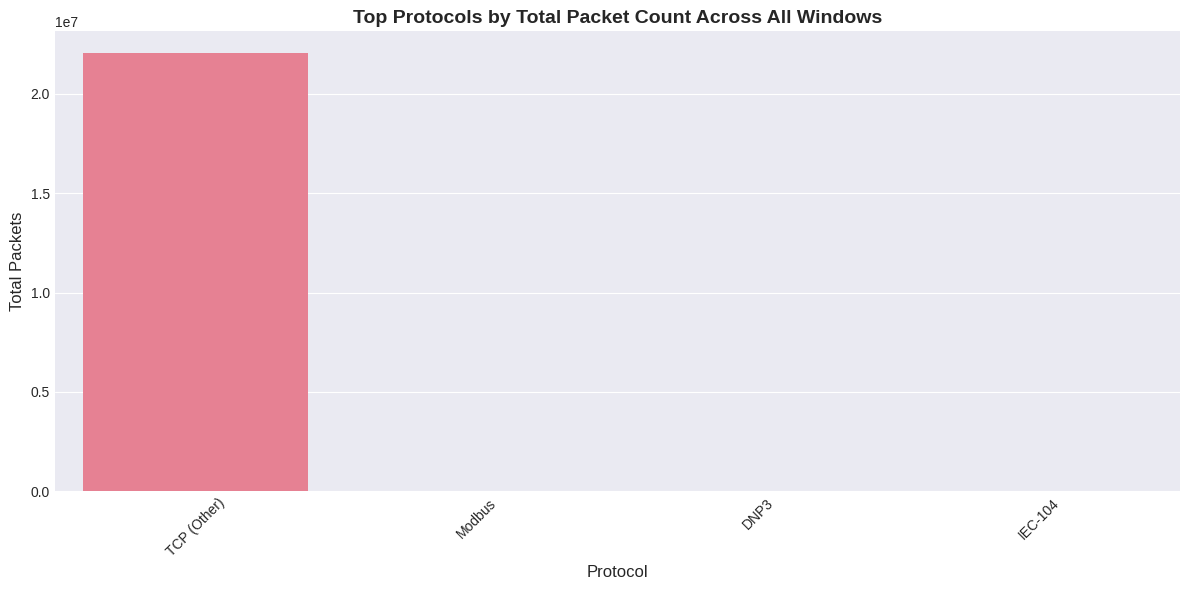

✓ Plot 1 saved


In [ ]:
# ==================== 1. Top 20 Protocol Distribution (from packet counts) ====================

def plot_top_protocols(df):
    """Aggregate protocol presence across windows"""
    fig, ax = plt.subplots(figsize=(12, 6))

    # Sum protocol-specific packet counts
    protocol_totals = {
        'Modbus': df['modbus_pkt_count'].sum(),
        'DNP3': df['dnp3_pkt_count'].sum(),
        'IEC-104': df['iec104_pkt_count'].sum(),
        'TCP (Other)': df['pkt_count'].sum() - (
            df['modbus_pkt_count'].sum() +
            df['dnp3_pkt_count'].sum() +
            df['iec104_pkt_count'].sum()
        )
    }

    protocol_df = pd.DataFrame(list(protocol_totals.items()),
                                columns=['Protocol', 'Total Packets'])
    protocol_df = protocol_df.sort_values('Total Packets', ascending=False).head(20)

    sns.barplot(data=protocol_df, x='Protocol', y='Total Packets', ax=ax)
    ax.set_title('Top Protocols by Total Packet Count Across All Windows', fontsize=14, fontweight='bold')
    ax.set_xlabel('Protocol', fontsize=12)
    ax.set_ylabel('Total Packets', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_plots/1_top_protocols.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 1 saved")

plot_top_protocols(df)

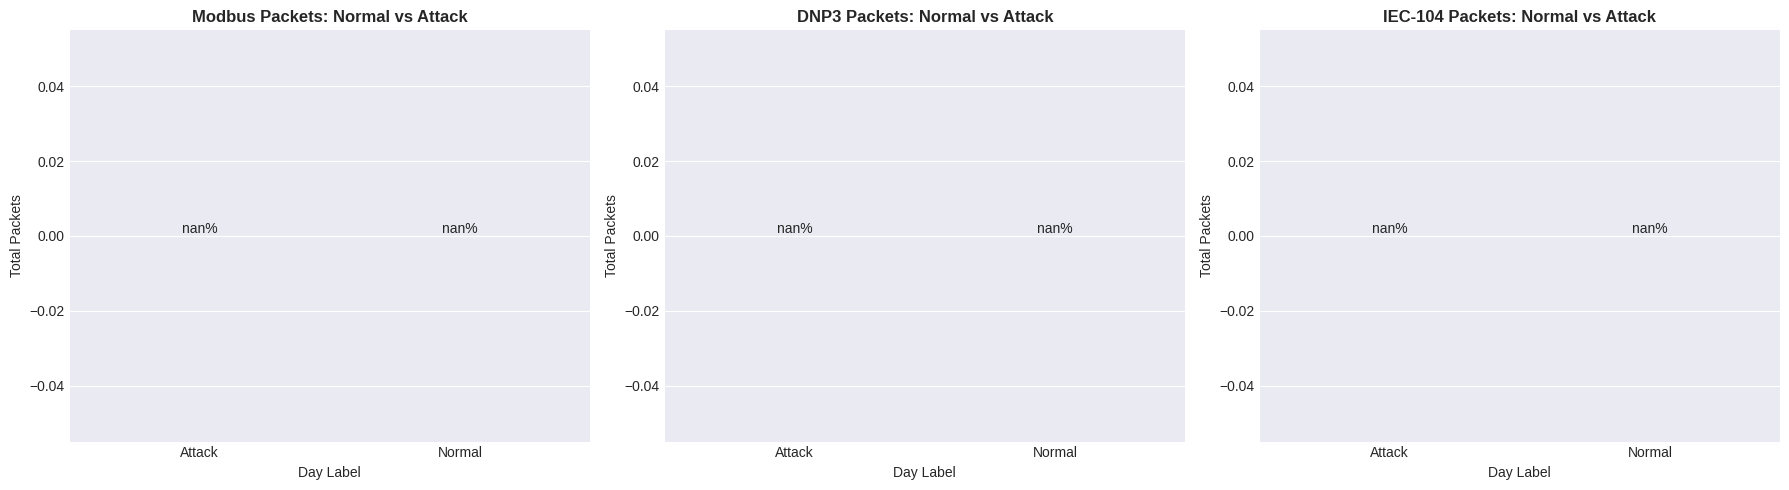

✓ Plot 2 saved


In [ ]:
# ==================== 2. Protocol Distribution by Day Label ====================

def plot_protocol_by_label(df):
    """Compare SCADA protocol usage: Normal vs Attack"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    protocols = [
        ('Modbus', 'modbus_pkt_count'),
        ('DNP3', 'dnp3_pkt_count'),
        ('IEC-104', 'iec104_pkt_count')
    ]

    for ax, (name, col) in zip(axes, protocols):
        data = df.groupby('day_label')[col].sum().reset_index()
        sns.barplot(data=data, x='day_label', y=col, ax=ax)
        ax.set_title(f'{name} Packets: Normal vs Attack', fontsize=12, fontweight='bold')
        ax.set_xlabel('Day Label')
        ax.set_ylabel('Total Packets')

        # Add percentage labels
        total = data[col].sum()
        for i, v in enumerate(data[col]):
            ax.text(i, v, f'{v/total*100:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_plots/2_protocol_by_label.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 2 saved")

plot_protocol_by_label(df)

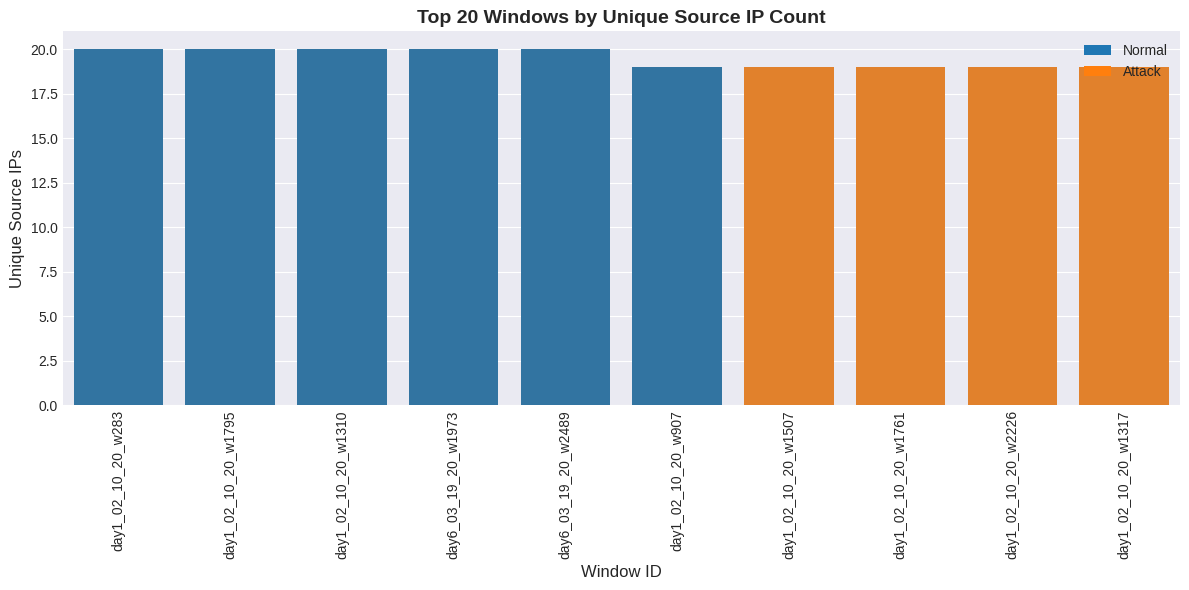

✓ Plot 3 saved


In [ ]:

# ==================== 3. Top 10 Windows by Unique Source IPs ====================

def plot_top_sources(df):
    """Windows with most unique source IPs"""
    fig, ax = plt.subplots(figsize=(12, 6))

    top_windows = df.nlargest(20, 'unique_srcs')[['source_file', 'win_idx', 'unique_srcs', 'day_label']]
    top_windows['window_id'] = top_windows['source_file'] + '_w' + top_windows['win_idx'].astype(str)

    colors = ['#ff7f0e' if label == 'Attack' else '#1f77b4'
              for label in top_windows['day_label']]

    sns.barplot(data=top_windows, x='window_id', y='unique_srcs',
                palette=colors, ax=ax)
    ax.set_title('Top 20 Windows by Unique Source IP Count', fontsize=14, fontweight='bold')
    ax.set_xlabel('Window ID', fontsize=12)
    ax.set_ylabel('Unique Source IPs', fontsize=12)
    ax.tick_params(axis='x', rotation=90)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#1f77b4', label='Normal'),
                       Patch(facecolor='#ff7f0e', label='Attack')]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_plots/3_top_sources.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 3 saved")

plot_top_sources(df)



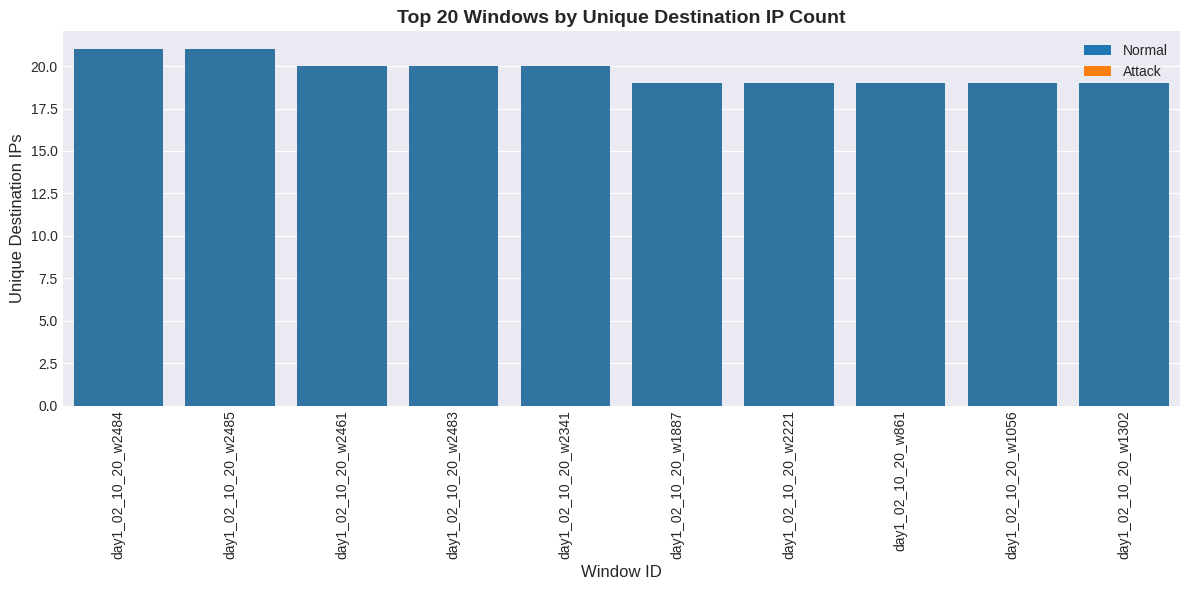

✓ Plot 4 saved


In [ ]:
# ==================== 4. Top 10 Windows by Unique Destination IPs ====================

def plot_top_destinations(df):
    """Windows with most unique destination IPs"""
    fig, ax = plt.subplots(figsize=(12, 6))

    top_windows = df.nlargest(20, 'unique_dsts')[['source_file', 'win_idx', 'unique_dsts', 'day_label']]
    top_windows['window_id'] = top_windows['source_file'] + '_w' + top_windows['win_idx'].astype(str)

    colors = ['#ff7f0e' if label == 'Attack' else '#1f77b4'
              for label in top_windows['day_label']]

    sns.barplot(data=top_windows, x='window_id', y='unique_dsts',
                palette=colors, ax=ax)
    ax.set_title('Top 20 Windows by Unique Destination IP Count', fontsize=14, fontweight='bold')
    ax.set_xlabel('Window ID', fontsize=12)
    ax.set_ylabel('Unique Destination IPs', fontsize=12)
    ax.tick_params(axis='x', rotation=90)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#1f77b4', label='Normal'),
                       Patch(facecolor='#ff7f0e', label='Attack')]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_plots/4_top_destinations.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 4 saved")

plot_top_destinations(df)




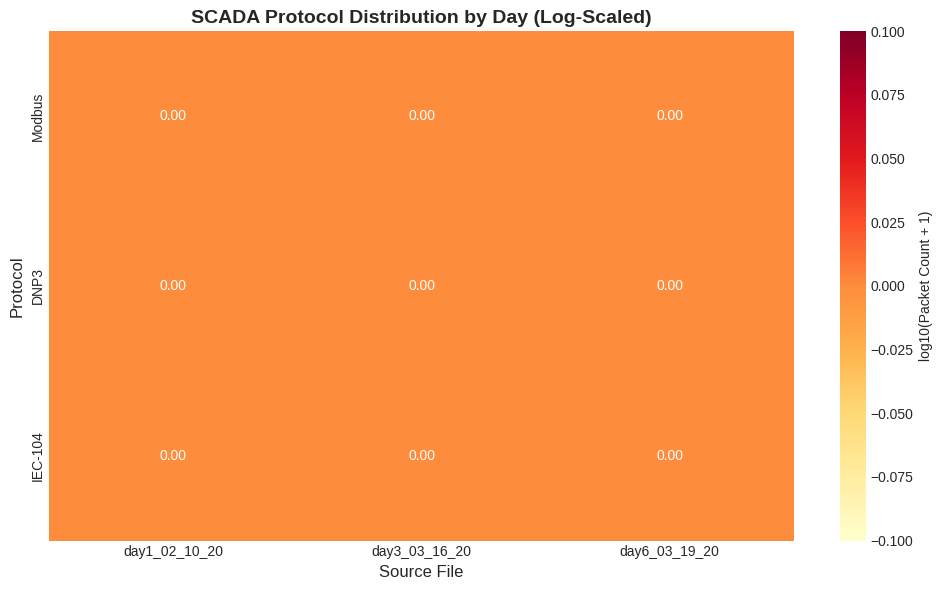

✓ Plot 5 saved


In [ ]:
# ==================== 5. Source File × SCADA Protocol Heatmap ====================

def plot_protocol_heatmap(df):
    """Heatmap of SCADA protocol distribution by source file"""
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create pivot table
    heatmap_data = df.groupby('source_file')[
        ['modbus_pkt_count', 'dnp3_pkt_count', 'iec104_pkt_count']
    ].sum()

    heatmap_data.columns = ['Modbus', 'DNP3', 'IEC-104']

    # Log scale for better visualization
    heatmap_data_log = np.log10(heatmap_data + 1)

    sns.heatmap(heatmap_data_log.T, annot=True, fmt='.2f', cmap='YlOrRd',
                cbar_kws={'label': 'log10(Packet Count + 1)'}, ax=ax)
    ax.set_title('SCADA Protocol Distribution by Day (Log-Scaled)',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Source File', fontsize=12)
    ax.set_ylabel('Protocol', fontsize=12)

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_plots/5_protocol_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 5 saved")

plot_protocol_heatmap(df)



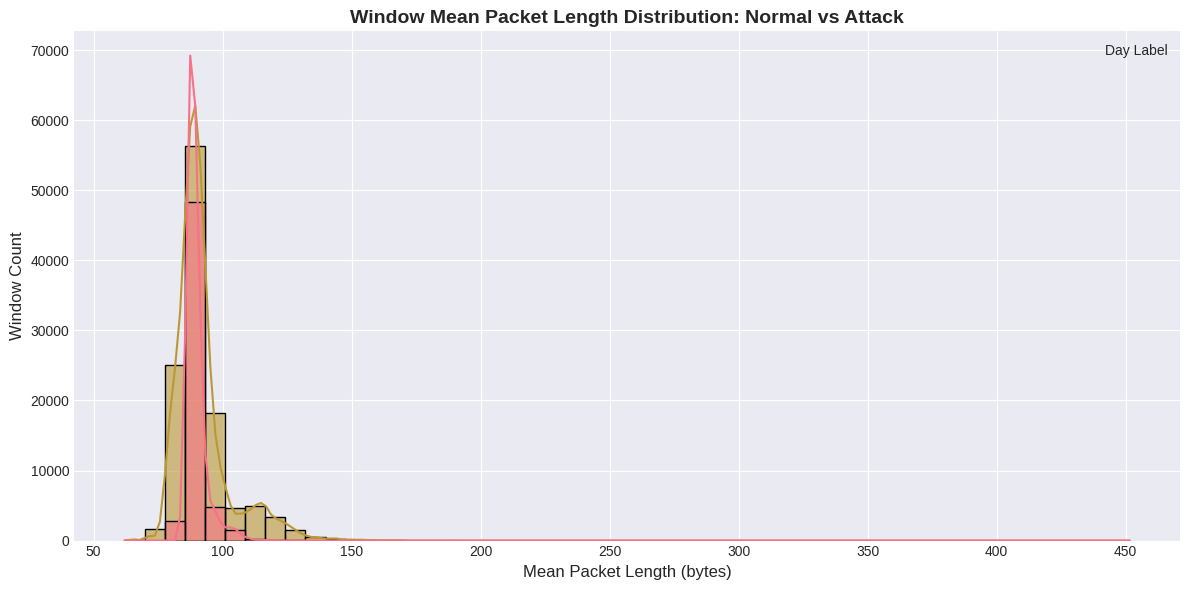

✓ Plot 6 saved


In [ ]:

# ==================== 6. Packet Length Distribution by Day Label ====================

def plot_length_distribution(df):
    """Compare mean packet lengths: Normal vs Attack"""
    fig, ax = plt.subplots(figsize=(12, 6))

    # Use mean_len from windows
    sns.histplot(data=df, x='mean_len', hue='day_label', bins=50,
                 kde=True, alpha=0.6, ax=ax)
    ax.set_title('Window Mean Packet Length Distribution: Normal vs Attack',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Mean Packet Length (bytes)', fontsize=12)
    ax.set_ylabel('Window Count', fontsize=12)
    ax.legend(title='Day Label')

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_plots/6_length_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 6 saved")

plot_length_distribution(df)



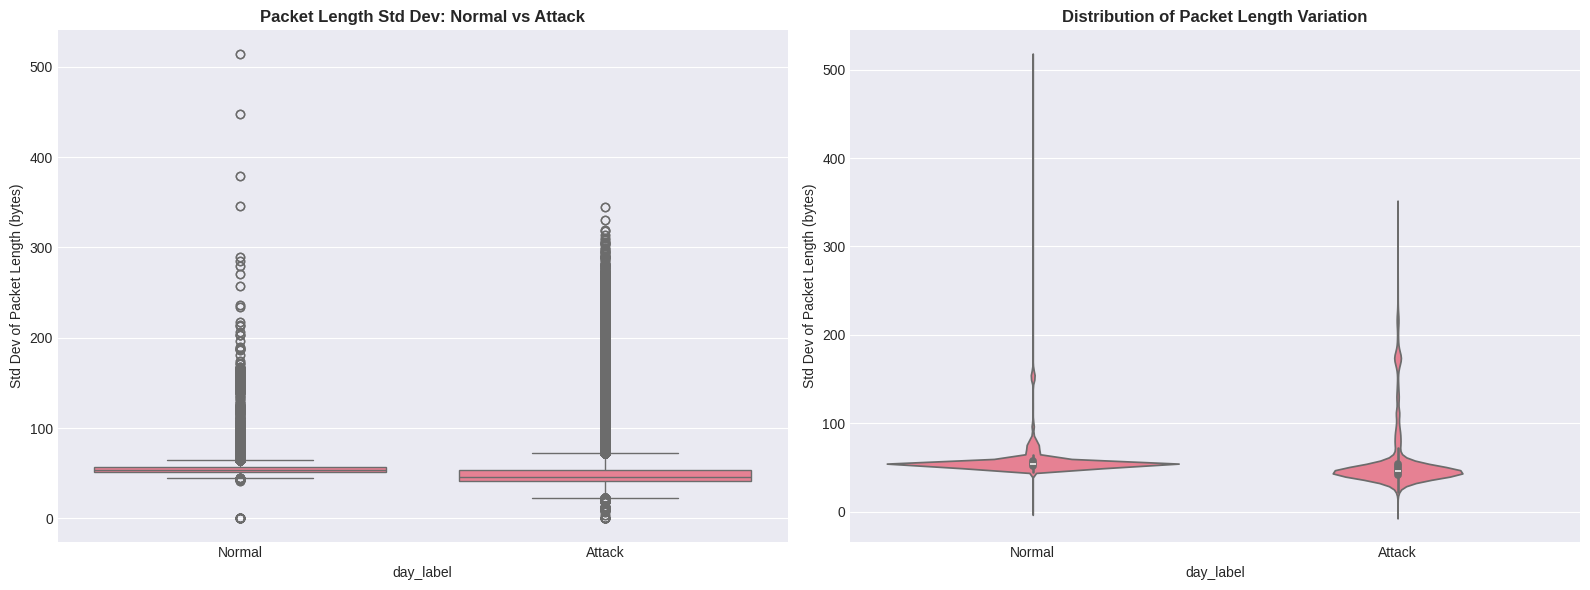

✓ Plot 7 saved


In [ ]:

# ==================== 7. Packet Length Variation: Normal vs Attack ====================

def plot_length_variation(df):
    """Compare packet length std deviation"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Box plot
    sns.boxplot(data=df, x='day_label', y='std_len', ax=axes[0])
    axes[0].set_title('Packet Length Std Dev: Normal vs Attack',
                      fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Std Dev of Packet Length (bytes)')

    # Violin plot
    sns.violinplot(data=df, x='day_label', y='std_len', ax=axes[1])
    axes[1].set_title('Distribution of Packet Length Variation',
                      fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Std Dev of Packet Length (bytes)')

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_plots/7_length_variation.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 7 saved")

plot_length_variation(df)




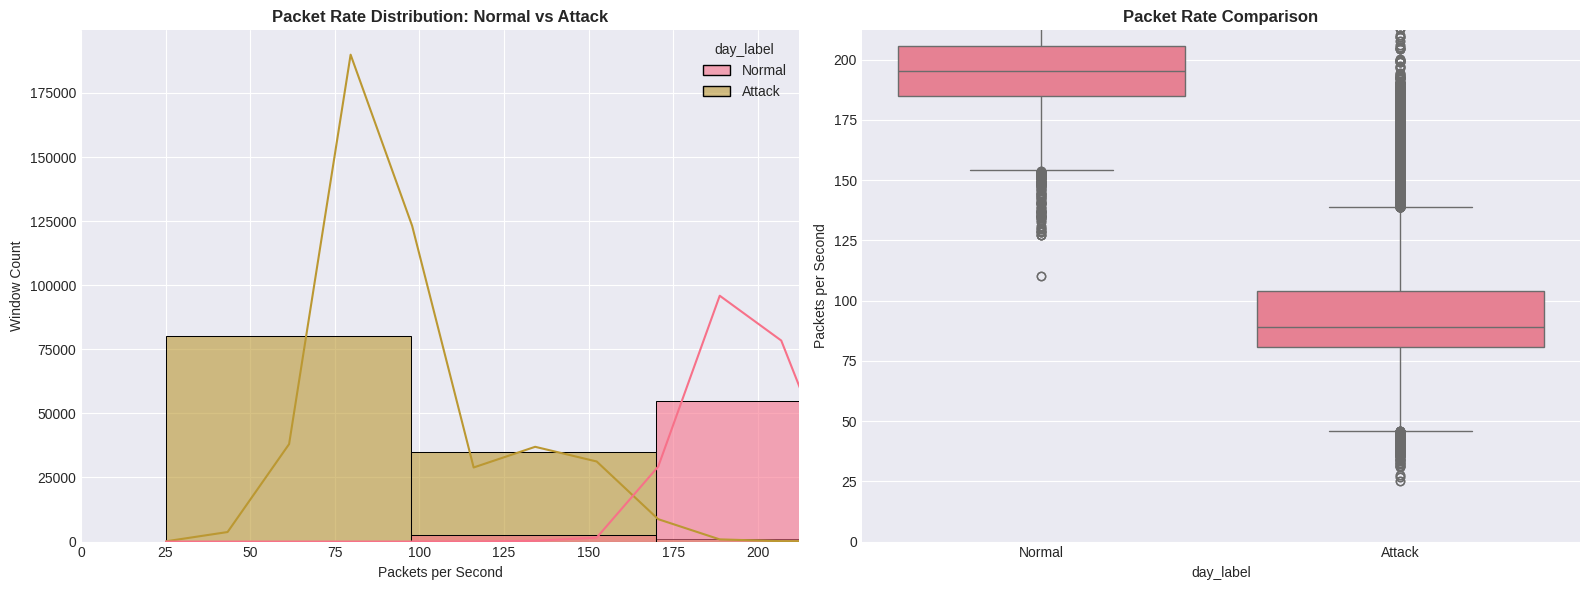

✓ Plot 8 saved


In [ ]:
# ==================== 8. Packets per Second: Normal vs Attack ====================

def plot_packets_per_second(df):
    """Traffic rate comparison"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Calculate packets per second (pkt_count / window duration)
    df['window_duration'] = df['t_end'] - df['t_start']
    df['pkt_rate'] = df['pkt_count'] / (df['window_duration'] + 0.001)  # Avoid division by zero

    # Histogram
    sns.histplot(data=df, x='pkt_rate', hue='day_label', bins=50,
                 kde=True, alpha=0.6, ax=axes[0])
    axes[0].set_title('Packet Rate Distribution: Normal vs Attack',
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Packets per Second')
    axes[0].set_ylabel('Window Count')
    axes[0].set_xlim(0, df['pkt_rate'].quantile(0.95))  # Remove outliers for clarity

    # Box plot
    sns.boxplot(data=df, x='day_label', y='pkt_rate', ax=axes[1])
    axes[1].set_title('Packet Rate Comparison', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Packets per Second')
    axes[1].set_ylim(0, df['pkt_rate'].quantile(0.95))

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_plots/8_packets_per_second.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 8 saved")

plot_packets_per_second(df)




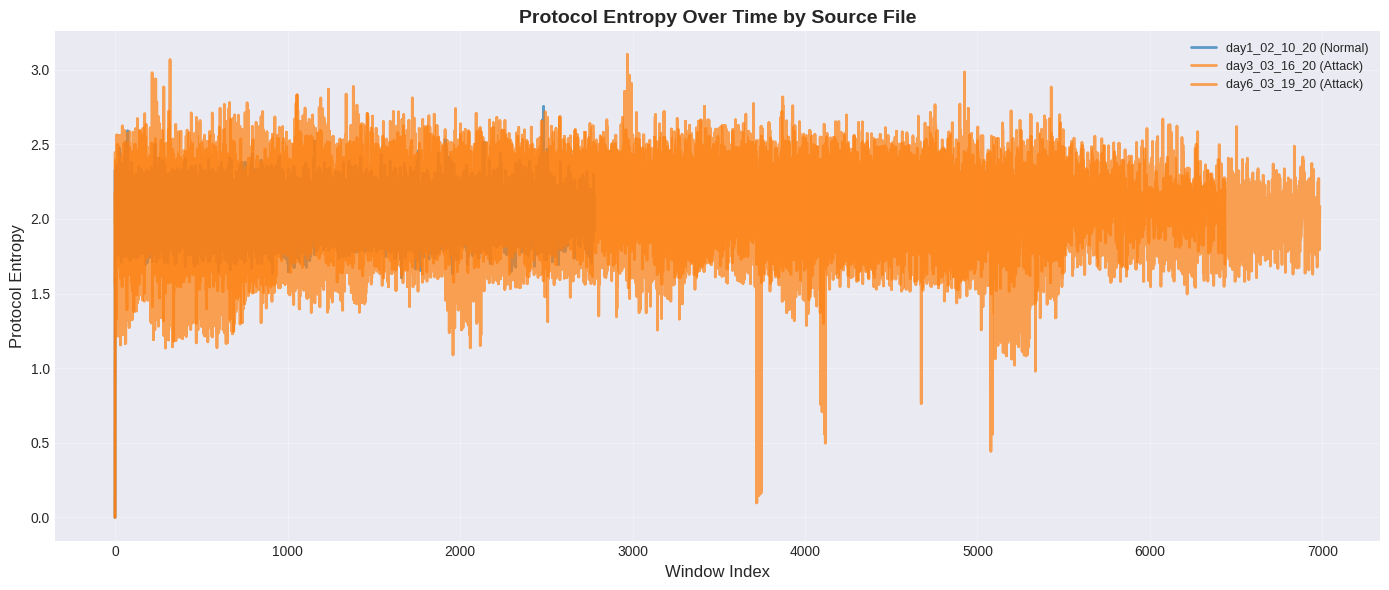

✓ Plot 9 saved


In [ ]:
# ==================== 9. Protocol Entropy Over Time ====================

def plot_entropy_timeline(df):
    """Protocol entropy evolution across files"""
    fig, ax = plt.subplots(figsize=(14, 6))

    for src_file in df['source_file'].unique():
        file_data = df[df['source_file'] == src_file].sort_values('win_idx')
        label = df[df['source_file'] == src_file]['day_label'].iloc[0]
        color = '#ff7f0e' if label == 'Attack' else '#1f77b4'

        ax.plot(file_data['win_idx'], file_data['protocol_entropy'],
                label=f"{src_file} ({label})", alpha=0.7, linewidth=2, color=color)

    ax.set_title('Protocol Entropy Over Time by Source File',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Window Index', fontsize=12)
    ax.set_ylabel('Protocol Entropy', fontsize=12)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_plots/9_entropy_timeline.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 9 saved")

plot_entropy_timeline(df)




In [ ]:
df.columns

Index(['win_idx', 'pkt_count', 'mean_len', 'std_len', 'min_len', 'max_len',
       'unique_srcs', 'unique_dsts', 't_start', 't_end', 'protocol_entropy',
       'modbus_pkt_count', 'modbus_unique_functions', 'modbus_exception_rate',
       'dnp3_pkt_count', 'dnp3_unique_functions', 'dnp3_iin_rate',
       'iec104_pkt_count', 'iec104_unique_types', 'level_1', 'time_rel',
       'source_file', 'day_label', 'window_duration', 'pkt_rate'],
      dtype='object')

Using features for clustering: ['pkt_count', 'mean_len', 'protocol_entropy', 'unique_srcs', 'unique_dsts', 'std_len', 'modbus_pkt_count', 'dnp3_pkt_count', 'iec104_pkt_count']


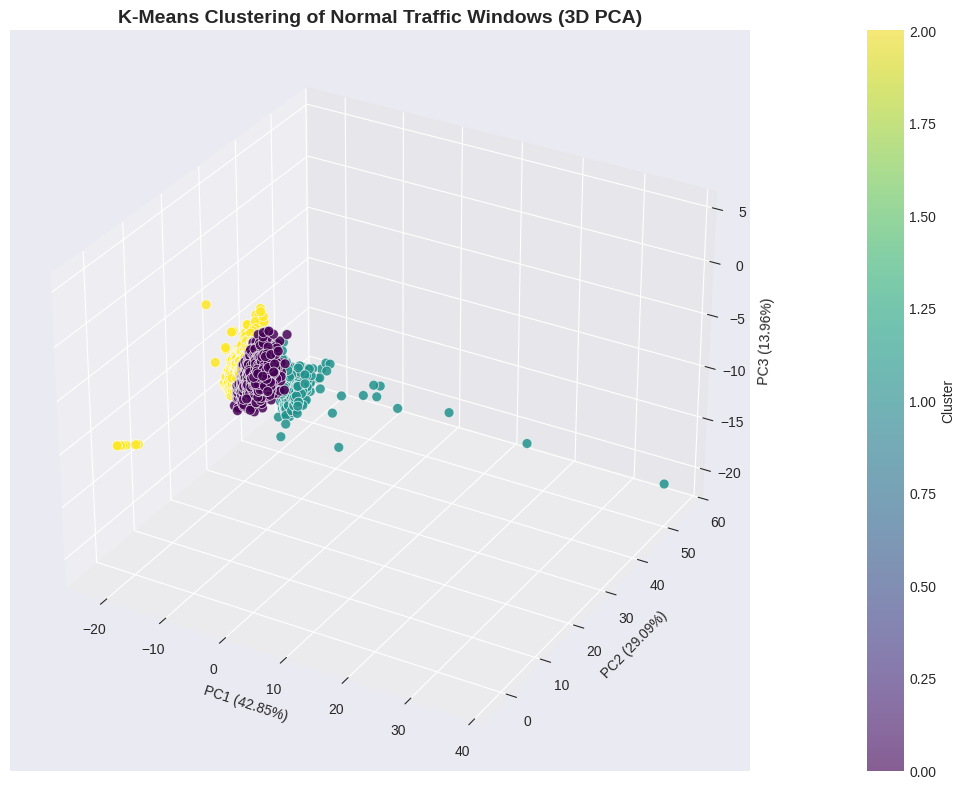

✓ Plot 10 saved
Explained variance: 85.90%


In [ ]:
# ==================== 10. K-Means Clustering of Normal Windows (3D) ====================

def plot_clustering_3d(df):
    """3D clustering visualization of normal traffic"""
    from mpl_toolkits.mplot3d import Axes3D

    # Filter normal windows
    normal_df = df[df['day_label'] == 'Normal'].copy()

    # Select features for clustering - check which columns exist
    possible_features = ['pkt_count', 'mean_len', 'protocol_entropy',
                         'unique_srcs', 'unique_dsts', 'std_len',
                         'modbus_pkt_count', 'dnp3_pkt_count', 'iec104_pkt_count']

    # Only use columns that exist in the dataframe
    feature_cols = [col for col in possible_features if col in df.columns]

    print(f"Using features for clustering: {feature_cols}")

    X = normal_df[feature_cols].fillna(0)

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # K-Means clustering
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    normal_df['cluster'] = kmeans.fit_predict(X_scaled)

    # PCA for 3D visualization
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                         c=normal_df['cluster'], cmap='viridis',
                         s=50, alpha=0.6, edgecolors='w', linewidth=0.5)

    ax.set_title('K-Means Clustering of Normal Traffic Windows (3D PCA)',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')

    plt.colorbar(scatter, label='Cluster', ax=ax, pad=0.1)

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_plots/10_clustering_3d.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 10 saved")
    print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

plot_clustering_3d(df)

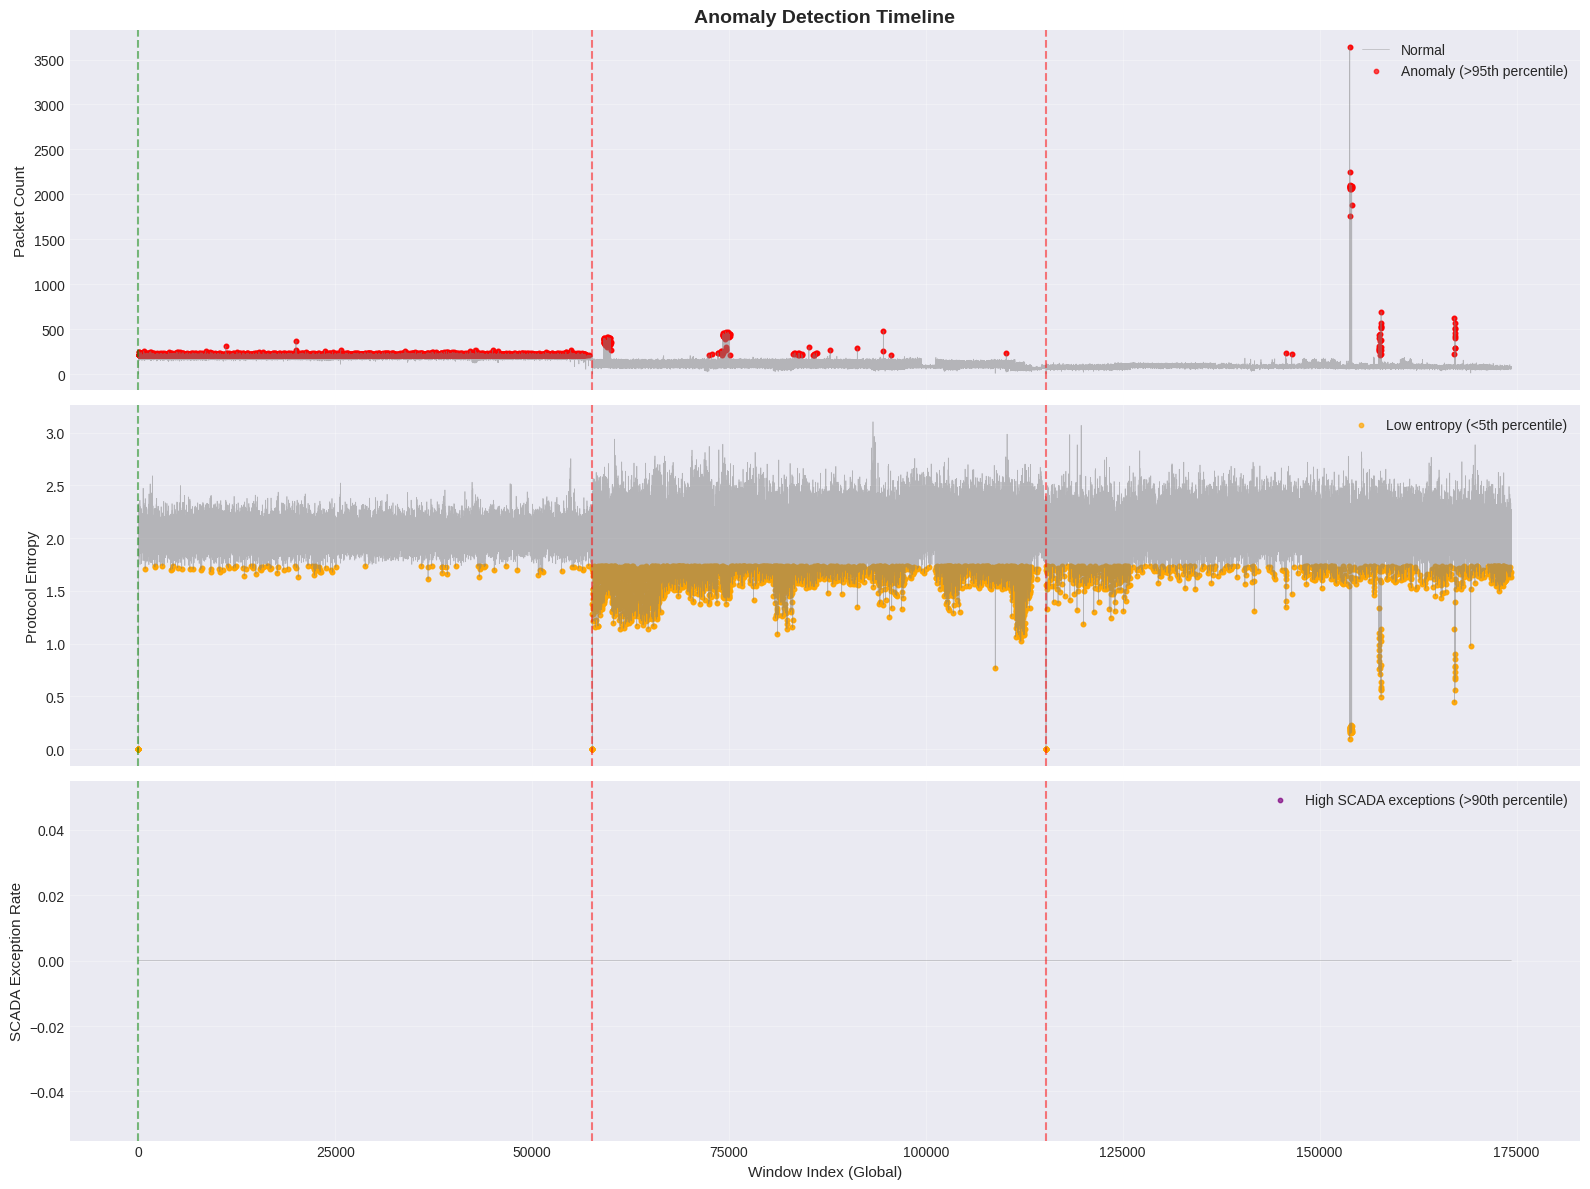

✓ Plot 11 saved


In [ ]:
# ==================== 11. Anomaly Timeline ====================

def plot_anomaly_timeline(df):
    """Timeline showing anomalous windows based on multiple features"""
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

    # Create continuous time axis
    df_sorted = df.sort_values(['source_file', 'win_idx']).reset_index(drop=True)
    df_sorted['global_time'] = range(len(df_sorted))

    # Mark day boundaries
    day_boundaries = df_sorted.groupby('source_file')['global_time'].min()

    # Plot 1: Packet count anomalies
    threshold_pkt = df_sorted['pkt_count'].quantile(0.95)
    anomaly_mask = df_sorted['pkt_count'] > threshold_pkt

    axes[0].plot(df_sorted['global_time'], df_sorted['pkt_count'],
                 alpha=0.5, linewidth=0.5, color='gray', label='Normal')
    axes[0].scatter(df_sorted.loc[anomaly_mask, 'global_time'],
                    df_sorted.loc[anomaly_mask, 'pkt_count'],
                    color='red', s=10, alpha=0.7, label='Anomaly (>95th percentile)')
    axes[0].set_ylabel('Packet Count', fontsize=11)
    axes[0].set_title('Anomaly Detection Timeline', fontsize=14, fontweight='bold')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Protocol entropy anomalies
    threshold_entropy = df_sorted['protocol_entropy'].quantile(0.05)
    anomaly_mask_entropy = df_sorted['protocol_entropy'] < threshold_entropy

    axes[1].plot(df_sorted['global_time'], df_sorted['protocol_entropy'],
                 alpha=0.5, linewidth=0.5, color='gray')
    axes[1].scatter(df_sorted.loc[anomaly_mask_entropy, 'global_time'],
                    df_sorted.loc[anomaly_mask_entropy, 'protocol_entropy'],
                    color='orange', s=10, alpha=0.7, label='Low entropy (<5th percentile)')
    axes[1].set_ylabel('Protocol Entropy', fontsize=11)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    # Plot 3: SCADA-specific anomalies
    df_sorted['scada_exception_rate'] = (
        df_sorted['modbus_exception_rate'] + df_sorted['dnp3_iin_rate']
    ) / 2

    threshold_exception = df_sorted['scada_exception_rate'].quantile(0.90)
    anomaly_mask_scada = df_sorted['scada_exception_rate'] > threshold_exception

    axes[2].plot(df_sorted['global_time'], df_sorted['scada_exception_rate'],
                 alpha=0.5, linewidth=0.5, color='gray')
    axes[2].scatter(df_sorted.loc[anomaly_mask_scada, 'global_time'],
                    df_sorted.loc[anomaly_mask_scada, 'scada_exception_rate'],
                    color='purple', s=10, alpha=0.7,
                    label='High SCADA exceptions (>90th percentile)')
    axes[2].set_ylabel('SCADA Exception Rate', fontsize=11)
    axes[2].set_xlabel('Window Index (Global)', fontsize=11)
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)

    # Add day boundaries
    for ax in axes:
        for day, pos in day_boundaries.items():
            label = df_sorted[df_sorted['source_file'] == day]['day_label'].iloc[0]
            color = 'red' if label == 'Attack' else 'green'
            ax.axvline(x=pos, color=color, linestyle='--', alpha=0.5, linewidth=1.5)

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_plots/11_anomaly_timeline.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 11 saved")

plot_anomaly_timeline(df)


In [ ]:


# ==================== Summary Statistics ====================

print("\n" + "="*60)
print("EDA SUMMARY STATISTICS")
print("="*60)

print("\n1. Window Statistics:")
print(f"   Total windows: {len(df)}")
print(f"   Normal windows: {len(df[df['day_label']=='Normal'])}")
print(f"   Attack windows: {len(df[df['day_label']=='Attack'])}")

print("\n2. SCADA Protocol Coverage:")
print(f"   Windows with Modbus: {(df['modbus_pkt_count']>0).sum()}")
print(f"   Windows with DNP3: {(df['dnp3_pkt_count']>0).sum()}")
print(f"   Windows with IEC-104: {(df['iec104_pkt_count']>0).sum()}")

print("\n3. Anomaly Indicators:")
print(f"   Avg protocol entropy (Normal): {df[df['day_label']=='Normal']['protocol_entropy'].mean():.3f}")
print(f"   Avg protocol entropy (Attack): {df[df['day_label']=='Attack']['protocol_entropy'].mean():.3f}")
print(f"   Avg packet rate (Normal): {df[df['day_label']=='Normal']['pkt_rate'].mean():.2f} pkt/s")
print(f"   Avg packet rate (Attack): {df[df['day_label']=='Attack']['pkt_rate'].mean():.2f} pkt/s")

print("\n✅ All 11 EDA plots saved to:", f"{OUT_DIR}/eda_plots/")
print("="*60)


EDA SUMMARY STATISTICS

1. Window Statistics:
   Total windows: 174344
   Normal windows: 57630
   Attack windows: 116714

2. SCADA Protocol Coverage:
   Windows with Modbus: 0
   Windows with DNP3: 0
   Windows with IEC-104: 0

3. Anomaly Indicators:
   Avg protocol entropy (Normal): 2.021
   Avg protocol entropy (Attack): 2.056
   Avg packet rate (Normal): 196.00 pkt/s
   Avg packet rate (Attack): 98.65 pkt/s

✅ All 11 EDA plots saved to: /content/drive/MyDrive/scada_analysis//eda_plots/


# Loading windowed data for model training

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                              ConfusionMatrixDisplay, roc_auc_score, roc_curve)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

# ==================== 1. DATA LOADING & PREPARATION ====================
OUT_DIR = '/content/drive/MyDrive/scada_analysis/'
win_df = pd.read_csv(f"{OUT_DIR}/scada_windowed_scada_aware.csv")

print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total windows: {len(win_df)}")
print(f"Normal windows: {len(win_df[win_df['day_label']=='Normal'])}")
print(f"Attack windows: {len(win_df[win_df['day_label']=='Attack'])}")


DATASET OVERVIEW
Total windows: 174344
Normal windows: 57630
Attack windows: 116714


In [ ]:
# ==================== 2. FEATURE ENGINEERING ====================

# Enhanced feature set with SCADA-specific features
features_basic = ['pkt_count', 'mean_len', 'std_len', 'min_len', 'max_len',
                  'unique_srcs', 'unique_dsts', 'protocol_entropy']

features_scada = ['modbus_pkt_count', 'modbus_unique_functions',
                  'modbus_exception_rate', 'dnp3_pkt_count',
                  'dnp3_unique_functions', 'dnp3_iin_rate',
                  'iec104_pkt_count', 'iec104_unique_types']

# Check which features exist and use them
available_features = [f for f in features_basic + features_scada if f in win_df.columns]
print(f"\n✓ Using {len(available_features)} features for training")
print("Features:", available_features[:10], "...")

# Split Normal vs Attack
normal_win = win_df[win_df['day_label'] == 'Normal'].copy()
attack_win = win_df[win_df['day_label'] == 'Attack'].copy()

X_normal = normal_win[available_features].fillna(0).values
X_attack = attack_win[available_features].fillna(0).values

# Further split normal data for validation
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

print(f"\nData split:")
print(f"  Training (Normal): {X_train.shape}")
print(f"  Validation (Normal): {X_val.shape}")
print(f"  Test (Attack): {X_attack.shape}")


✓ Using 16 features for training
Features: ['pkt_count', 'mean_len', 'std_len', 'min_len', 'max_len', 'unique_srcs', 'unique_dsts', 'protocol_entropy', 'modbus_pkt_count', 'modbus_unique_functions'] ...

Data split:
  Training (Normal): (46104, 16)
  Validation (Normal): (11526, 16)
  Test (Attack): (116714, 16)


In [ ]:

# ==================== 3. FEATURE SCALING ====================

# Use RobustScaler for better handling of outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_attack_scaled = scaler.transform(X_attack)

input_dim = X_train_scaled.shape[1]


MODEL 1: DEEP STACKED AUTOENCODER


Model: "deep_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,840 (11.09 KB)

 Trainable params: 2,632 (10.28 KB)

 Non-trainable params: 208 (832.00 B)

Epoch 1/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 1.5222 - mae: 0.6240 - val_loss: 0.4513 - val_mae: 0.2040 - learning_rate: 0.0010
Epoch 2/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5967 - mae: 0.2852 - val_loss: 0.4377 - val_mae: 0.1818 - learning_rate: 0.0010
Epoch 3/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5399 - mae: 0.2377 - val_loss: 0.4289 - val_mae: 0.1763 - learning_rate: 0.0010
Epoch 4/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5066 - mae: 0.2256 - val_loss: 0.4166 - val_mae: 0.1693 - learning_rate: 0.0010
Epoch 5/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4669 - mae: 0.2213 - val_loss: 0.3978 - val_mae: 0.1582 - learning_rate: 0.0010
Epoch 6/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4419 - mae: 0.2187 - val_loss: 0.3967 - val_mae: 0.1627 - learning_rate: 0.0010
Epoch 7/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4163 - mae: 0.2165 - val_loss: 0.4000 - val_mae: 0.1613 - learning_rate: 0.00

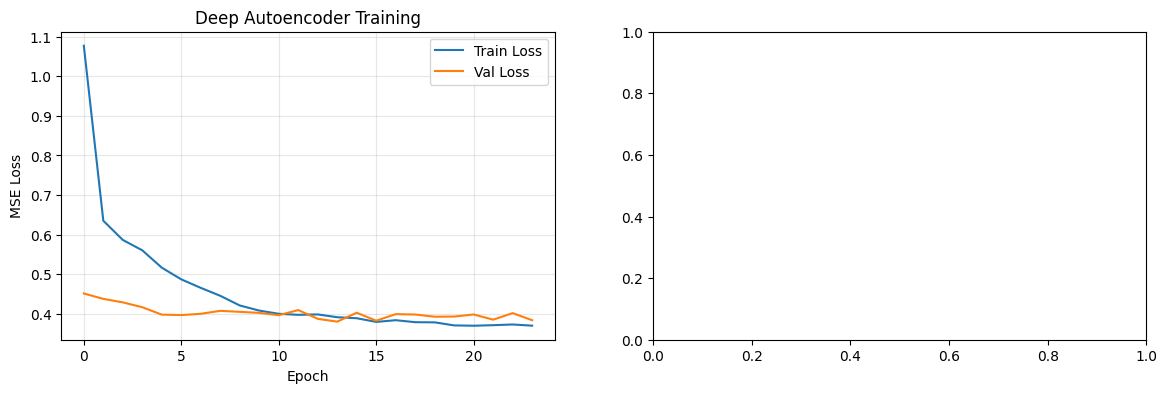

In [ ]:
# ==================== 4. MODEL 1: DEEP STACKED AUTOENCODER ====================

print("\n" + "="*60)
print("MODEL 1: DEEP STACKED AUTOENCODER")
print("="*60)

def create_deep_autoencoder(input_dim, encoding_dims=[32, 16, 8]):
    """
    Deep stacked autoencoder with hierarchical feature learning
    """
    # Encoder
    encoder_input = layers.Input(shape=(input_dim,))
    x = encoder_input

    for i, dim in enumerate(encoding_dims):
        x = layers.Dense(dim, activation='relu',
                        kernel_regularizer=regularizers.l2(1e-5),
                        name=f'encoder_{i+1}')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

    encoded = x

    # Decoder
    for i, dim in enumerate(reversed(encoding_dims[:-1])):
        x = layers.Dense(dim, activation='relu',
                        kernel_regularizer=regularizers.l2(1e-5),
                        name=f'decoder_{i+1}')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

    decoded = layers.Dense(input_dim, activation='linear', name='output')(x)

    # Full autoencoder
    autoencoder = models.Model(encoder_input, decoded, name='deep_autoencoder')

    # Encoder model for latent representation
    encoder = models.Model(encoder_input, encoded, name='encoder')

    return autoencoder, encoder

# Create and compile
ae_deep, encoder_deep = create_deep_autoencoder(input_dim, encoding_dims=[32, 16, 8])
ae_deep.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='mse', metrics=['mae'])

ae_deep.summary()

# Callbacks
callbacks_ae = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Train
history_ae = ae_deep.fit(
    X_train_scaled, X_train_scaled,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=callbacks_ae,
    verbose=1
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(history_ae.history['loss'], label='Train Loss')
axes[0].plot(history_ae.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Deep Autoencoder Training')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

In [ ]:
# ==================== 5. MODEL 2: VARIATIONAL AUTOENCODER (VAE) ====================

print("\n" + "="*60)
print("MODEL 2: VARIATIONAL AUTOENCODER (VAE)")
print("="*60)

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a window."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def create_vae(input_dim, latent_dim=8):
    """
    Variational Autoencoder for handling data imbalance
    """
    # Encoder
    encoder_inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(32, activation='relu')(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    decoder_outputs = layers.Dense(input_dim, activation='linear')(x)

    decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')

    # VAE Model
    class VAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

        def call(self, inputs):
            """Forward pass through VAE"""
            z_mean, z_log_var, z = self.encoder(inputs)
            reconstruction = self.decoder(z)
            return reconstruction

        def train_step(self, data):
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = self.encoder(data)
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction))
                kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
                total_loss = reconstruction_loss + 0.1 * kl_loss  # Beta-VAE

            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)

            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }

        def test_step(self, data):
            """Validation step"""
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            total_loss = reconstruction_loss + 0.1 * kl_loss

            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)

            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }

    vae = VAE(encoder, decoder)
    return vae

# Create and compile VAE
vae = create_vae(input_dim, latent_dim=8)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Train VAE
history_vae = vae.fit(
    X_train_scaled,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_scaled,),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

# Plot VAE training
axes[1].plot(history_vae.history['reconstruction_loss'], label='Recon Loss')
axes[1].plot(history_vae.history['kl_loss'], label='KL Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('VAE Training')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/model_training_curves.png", dpi=300, bbox_inches='tight')
plt.show()


MODEL 2: VARIATIONAL AUTOENCODER (VAE)
Epoch 1/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - kl_loss: 451.7979 - loss: 120.3038 - reconstruction_loss: 75.1240 - val_kl_loss: 0.7091 - val_loss: 0.5457 - val_reconstruction_loss: 0.4748
Epoch 2/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - kl_loss: 0.7550 - loss: 0.3225 - reconstruction_loss: 0.2470 - val_kl_loss: 0.8222 - val_loss: 0.4663 - val_reconstruction_loss: 0.3841
Epoch 3/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 0.8320 - loss: 0.2627 - reconstruction_loss: 0.1795 - val_kl_loss: 0.8868 - val_loss: 0.4173 - val_reconstruction_loss: 0.3286
Epoch 4/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 0.8574 - loss: 0.2315 - reconstruction_loss: 0.1457 - val_kl_loss: 0.8895 - val_loss: 0.3823 - val_reconstruction_loss: 0.2934
Epoch 5/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 0.8369 - loss: 0.2113 - reconstruction_loss: 0.1276 - val_kl_loss: 0.8374 - val_loss: 0.3525 - val_reconstruction_loss: 0.268

<Figure size 640x480 with 0 Axes>

In [ ]:
# ==================== 6. MODEL 3: LSTM FOR TEMPORAL MODELING ====================

print("\n" + "="*60)
print("MODEL 3: LSTM TEMPORAL AUTOENCODER")
print("="*60)

def create_temporal_sequences(X, seq_length=10):
    """Create sequences for LSTM"""
    sequences = []
    for i in range(len(X) - seq_length + 1):
        sequences.append(X[i:i+seq_length])
    return np.array(sequences)

# Create sequences
seq_length = 10
X_train_seq = create_temporal_sequences(X_train_scaled, seq_length)
X_val_seq = create_temporal_sequences(X_val_scaled, seq_length)

print(f"Sequence shape: {X_train_seq.shape}")

def create_lstm_autoencoder(seq_length, n_features, lstm_units=32):
    """
    LSTM autoencoder for temporal pattern learning
    """
    # Encoder
    encoder_inputs = layers.Input(shape=(seq_length, n_features))
    x = layers.LSTM(lstm_units, activation='relu', return_sequences=True)(encoder_inputs)
    x = layers.Dropout(0.2)(x)
    encoder_outputs = layers.LSTM(lstm_units//2, activation='relu', return_sequences=False)(x)

    # Repeat vector for decoder
    x = layers.RepeatVector(seq_length)(encoder_outputs)

    # Decoder
    x = layers.LSTM(lstm_units//2, activation='relu', return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(lstm_units, activation='relu', return_sequences=True)(x)
    decoder_outputs = layers.TimeDistributed(layers.Dense(n_features))(x)

    lstm_ae = models.Model(encoder_inputs, decoder_outputs, name='lstm_autoencoder')
    return lstm_ae

# Create and compile
lstm_ae = create_lstm_autoencoder(seq_length, input_dim, lstm_units=32)
lstm_ae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

lstm_ae.summary()

# Train
history_lstm = lstm_ae.fit(
    X_train_seq, X_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_seq, X_val_seq),
    callbacks=[EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)],
    verbose=1
)


MODEL 3: LSTM TEMPORAL AUTOENCODER
Sequence shape: (46095, 10, 16)


Model: "lstm_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 16)         │           528 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,320 (71.56 KB)

 Trainable params: 18,320 (71.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 1.2660 - val_loss: 0.7756
Epoch 2/50
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6740 - val_loss: 0.7303
Epoch 3/50
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6197 - val_loss: 0.7037
Epoch 4/50
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.6003 - val_loss: 0.6891
Epoch 5/50
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.5685 - val_loss: 0.7243
Epoch 6/50
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.5899 - val_loss: 0.7071
Epoch 7/50
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.5484 - val_loss: 0.6770
Epoch 8/50
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.5335 - val_loss: 0.6482
Epoch 9/50
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.5161 - val_loss: 0.6261
Epoch 10/50
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.4944 - val_loss: 0.6101
Epoch 11/50
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.4772 - val_loss: 0.6125
Epoch 12/50
1441/1441 ━━━

In [ ]:
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.3 MB/s eta 0:00:00


In [ ]:
# ==================== 7. SYNTHETIC ATTACK GENERATION WITH CTGAN ====================

print("\n" + "="*60)
print("GENERATING SYNTHETIC ATTACKS WITH CTGAN")
print("="*60)

try:
    from ctgan import CTGAN

    # Prepare attack data for CTGAN
    attack_df = attack_win[available_features].copy()
    attack_df['label'] = 'Attack'

    # Train CTGAN on attack data
    print("Training CTGAN on attack patterns...")
    ctgan = CTGAN(epochs=50, verbose=True)
    ctgan.fit(attack_df, discrete_columns=['label'])

    # Generate synthetic attacks
    n_synthetic = len(attack_win) // 2
    synthetic_attacks = ctgan.sample(n_synthetic)
    synthetic_attacks = synthetic_attacks.drop('label', axis=1)

    X_synthetic = scaler.transform(synthetic_attacks[available_features].fillna(0).values)

    print(f"✓ Generated {n_synthetic} synthetic attack windows")

except ImportError:
    print("⚠️  CTGAN not installed. Install with: pip install ctgan")
    print("Skipping synthetic data generation...")
    X_synthetic = None


GENERATING SYNTHETIC ATTACKS WITH CTGAN
Training CTGAN on attack patterns...


Gen. (-0.29) | Discrim. (-0.44): 100%|██████████| 50/50 [06:06<00:00,  7.33s/it]


✓ Generated 58357 synthetic attack windows


In [ ]:
# ==================== 8. ANOMALY DETECTION & EVALUATION ====================

print("\n" + "="*60)
print("ANOMALY DETECTION EVALUATION")
print("="*60)

# Get reconstruction errors from all models
def get_reconstruction_error(model, X):
    """Calculate MSE reconstruction error"""
    X_pred = model.predict(X, verbose=0)
    return np.mean((X - X_pred) ** 2, axis=1)

def get_vae_reconstruction_error(vae_model, X):
    """Calculate VAE reconstruction error (encode then decode)"""
    X_recon = vae_model.predict(X, verbose=0)
    return np.mean((X - X_recon) ** 2, axis=1)

# Deep AE
recon_train_ae = get_reconstruction_error(ae_deep, X_train_scaled)
recon_val_ae = get_reconstruction_error(ae_deep, X_val_scaled)
recon_attack_ae = get_reconstruction_error(ae_deep, X_attack_scaled)

# VAE (use the full VAE model, not just decoder)
recon_train_vae = get_vae_reconstruction_error(vae, X_train_scaled)
recon_val_vae = get_vae_reconstruction_error(vae, X_val_scaled)
recon_attack_vae = get_vae_reconstruction_error(vae, X_attack_scaled)

# LSTM (need sequences)
X_attack_seq = create_temporal_sequences(X_attack_scaled, seq_length)
recon_train_lstm = get_reconstruction_error(lstm_ae, X_train_seq[:, :, :]).mean(axis=1)
recon_attack_lstm = get_reconstruction_error(lstm_ae, X_attack_seq[:, :, :]).mean(axis=1)

# Set thresholds (99th percentile of normal training data)
threshold_ae = np.percentile(recon_train_ae, 99)
threshold_vae = np.percentile(recon_train_vae, 99)
threshold_lstm = np.percentile(recon_train_lstm, 99)

print(f"\nAnomaly Thresholds:")
print(f"  Deep AE:  {threshold_ae:.6f}")
print(f"  VAE:      {threshold_vae:.6f}")
print(f"  LSTM AE:  {threshold_lstm:.6f}")

# Ensemble prediction (voting)
def ensemble_predict(recon_ae, recon_vae, recon_lstm,
                     thresh_ae, thresh_vae, thresh_lstm, voting='majority'):
    """Ensemble anomaly detection"""
    pred_ae = (recon_ae > thresh_ae).astype(int)
    pred_vae = (recon_vae > thresh_vae).astype(int)
    pred_lstm = (recon_lstm > thresh_lstm).astype(int)

    if voting == 'majority':
        return ((pred_ae + pred_vae + pred_lstm) >= 2).astype(int)
    elif voting == 'any':
        return ((pred_ae + pred_vae + pred_lstm) >= 1).astype(int)
    else:  # unanimous
        return ((pred_ae + pred_vae + pred_lstm) == 3).astype(int)

# Evaluate each model
models_results = {}

for model_name, recon_normal, recon_attack, threshold in [
    ('Deep AE', recon_val_ae, recon_attack_ae, threshold_ae),
    ('VAE', recon_val_vae, recon_attack_vae, threshold_vae),
    ('LSTM AE', recon_train_lstm[-len(recon_val_ae):], recon_attack_lstm, threshold_lstm)
]:
    y_true = np.concatenate([np.zeros(len(recon_normal)), np.ones(len(recon_attack))])
    y_scores = np.concatenate([recon_normal, recon_attack])
    y_pred = (y_scores > threshold).astype(int)

    print(f"\n{'='*60}")
    print(f"{model_name} RESULTS")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

    auc = roc_auc_score(y_true, y_scores)
    print(f"ROC AUC: {auc:.4f}")

    models_results[model_name] = {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_scores': y_scores,
        'auc': auc,
        'threshold': threshold
    }

# Ensemble evaluation
print(f"\n{'='*60}")
print("ENSEMBLE MODEL (MAJORITY VOTING)")
print(f"{'='*60}")

# Align sequence lengths for ensemble
min_len = min(len(recon_attack_ae), len(recon_attack_vae), len(recon_attack_lstm))
ensemble_pred_attack = ensemble_predict(
    recon_attack_ae[:min_len],
    recon_attack_vae[:min_len],
    recon_attack_lstm[:min_len],
    threshold_ae, threshold_vae, threshold_lstm
)

min_len_val = min(len(recon_val_ae), len(recon_val_vae), len(recon_train_lstm[-len(recon_val_ae):]))
ensemble_pred_normal = ensemble_predict(
    recon_val_ae[:min_len_val],
    recon_val_vae[:min_len_val],
    recon_train_lstm[-len(recon_val_ae):][:min_len_val],
    threshold_ae, threshold_vae, threshold_lstm
)

y_true_ensemble = np.concatenate([np.zeros(min_len_val), np.ones(min_len)])
y_pred_ensemble = np.concatenate([ensemble_pred_normal, ensemble_pred_attack])

print(classification_report(y_true_ensemble, y_pred_ensemble, target_names=['Normal', 'Attack']))



ANOMALY DETECTION EVALUATION

Anomaly Thresholds:
  Deep AE:  0.666985
  VAE:      0.179334
  LSTM AE:  4.616767

Deep AE RESULTS
              precision    recall  f1-score   support

      Normal       0.55      0.99      0.70     11526
      Attack       1.00      0.92      0.96    116714

    accuracy                           0.93    128240
   macro avg       0.77      0.95      0.83    128240
weighted avg       0.96      0.93      0.93    128240

ROC AUC: 0.9950

VAE RESULTS
              precision    recall  f1-score   support

      Normal       0.73      0.99      0.84     11526
      Attack       1.00      0.96      0.98    116714

    accuracy                           0.97    128240
   macro avg       0.87      0.98      0.91    128240
weighted avg       0.98      0.97      0.97    128240

ROC AUC: 0.9970

LSTM AE RESULTS
              precision    recall  f1-score   support

      Normal       0.13      0.99      0.22     11526
      Attack       1.00      0.32      0.49 

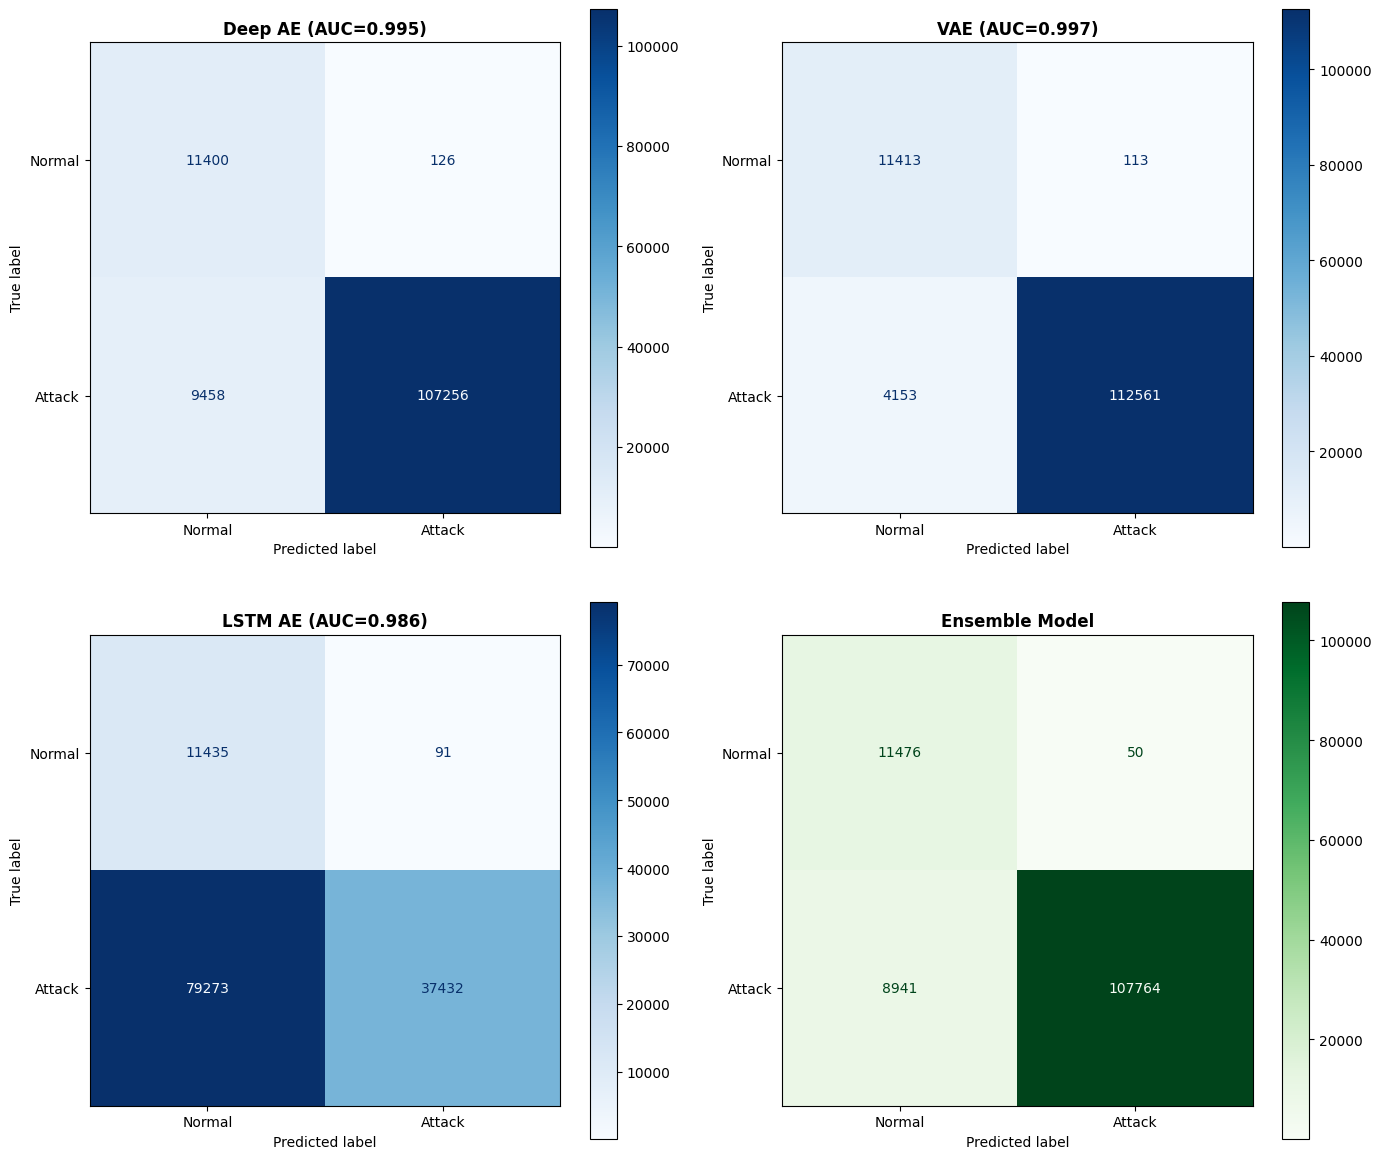

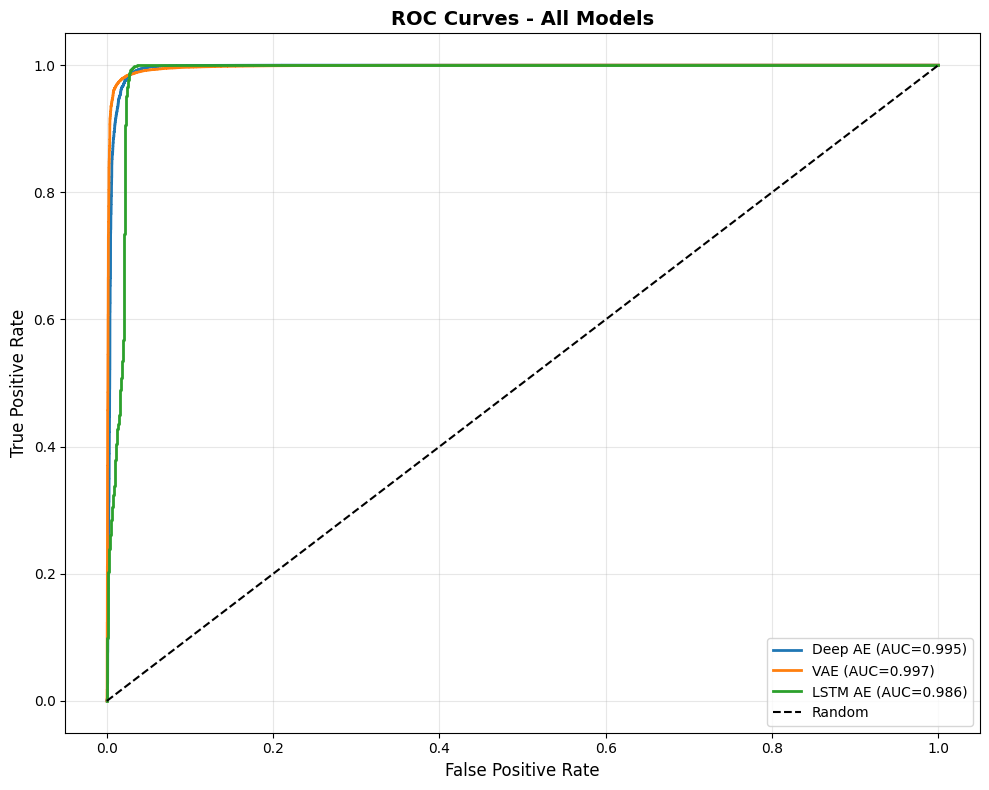

In [ ]:
# ==================== 9. VISUALIZATION ====================

# Confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (model_name, results) in enumerate(models_results.items()):
    cm = confusion_matrix(results['y_true'], results['y_pred'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Attack'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{model_name} (AUC={results["auc"]:.3f})', fontweight='bold')

# Ensemble confusion matrix
cm_ensemble = confusion_matrix(y_true_ensemble, y_pred_ensemble)
disp_ensemble = ConfusionMatrixDisplay(cm_ensemble, display_labels=['Normal', 'Attack'])
disp_ensemble.plot(ax=axes[3], cmap='Greens', values_format='d')
axes[3].set_title('Ensemble Model', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

# ROC Curves
plt.figure(figsize=(10, 8))
for model_name, results in models_results.items():
    fpr, tpr, _ = roc_curve(results['y_true'], results['y_scores'])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={results['auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/roc_curves.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ==================== 10. SAVE RESULTS ====================

# Save models
ae_deep.save(f"{OUT_DIR}/deep_autoencoder.keras")
vae.encoder.save(f"{OUT_DIR}/vae_encoder.keras")
vae.decoder.save(f"{OUT_DIR}/vae_decoder.keras")
lstm_ae.save(f"{OUT_DIR}/lstm_autoencoder.keras")

# Save results to CSV
results_df = pd.DataFrame({
    'model': list(models_results.keys()),
    'auc': [r['auc'] for r in models_results.values()],
    'threshold': [r['threshold'] for r in models_results.values()]
})
results_df.to_csv(f"{OUT_DIR}/model_results.csv", index=False)

print("\n" + "="*60)
print("✅ ALL MODELS TRAINED AND EVALUATED")
print("="*60)
print(f"Models saved to: {OUT_DIR}/")
print(f"Plots saved to: {OUT_DIR}/")
print("\nFiles created:")
print("  - deep_autoencoder.keras")
print("  - vae_encoder.keras, vae_decoder.keras")
print("  - lstm_autoencoder.keras")
print("  - model_training_curves.png")
print("  - confusion_matrices.png")
print("  - roc_curves.png")
print("  - model_results.csv")


✅ ALL MODELS TRAINED AND EVALUATED
Models saved to: /content/drive/MyDrive/scada_analysis//
Plots saved to: /content/drive/MyDrive/scada_analysis//

Files created:
  - deep_autoencoder.keras
  - vae_encoder.keras, vae_decoder.keras
  - lstm_autoencoder.keras
  - model_training_curves.png
  - confusion_matrices.png
  - roc_curves.png
  - model_results.csv
